In [93]:
import pandas as pd

# Remplacez 'nom_du_fichier.csv' par le chemin de votre fichier CSV
data = pd.read_csv("cities_africa.csv", sep = ";")
data_clean = data[['Name', 'Population', 'Coordinates']]  # Remplacez 'colonne1', 'colonne2', 'colonne3' par les noms de vos colonnes
nouvelles_colonnes = data['Coordinates'].str.split(',', expand=True)

# Renommer les nouvelles colonnes
nouvelles_colonnes.columns = ['lon', 'lat']

# Concaténer les nouvelles colonnes avec le DataFrame d'origine en supprimant la colonne d'origine
data_clean = pd.concat([data_clean, nouvelles_colonnes], axis=1).drop(columns=['Coordinates'])


In [97]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


lons = data_clean["lon"] 
lons = np.array(lons)
lons = lons.astype(float)
lats = data_clean["lat"]  
lats = np.array(lats)
lats = lats.astype(float)
population = data_clean["Population"]
population = np.array(population)
population = population.astype(float)


In [256]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 1000) : 
    return 1/(1+np.exp(-M*(x-center)))

In [313]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint

import numpy as np


@numba.jit(nopython = True)
def haversine(lat1, lon1, lat2, lon2):
  
    # Rayon moyen de la Terre en mètres
    R = 6371000

    # Convertir les degrés en radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Différences de latitude et de longitude
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Formule de la distance géodésique (haversine)
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance**2


Hs = 36000
N = 10
Is = 1e16
Imin = 1

@numba.jit(nopython = True, parallel = True)
def objectif(x) : 
    
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = haversine(lats[j], lons[j], x[2*i+1], x[2*i]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sumj
        
    return -somme
    


@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = haversine(lats[j], lons[j], x[2*i+1], x[2*i]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/(population[j]+0.1), center = Imin, M = 1e10)*population[j]
    return -0.8*sum(population)+somme
           
myc = NonlinearConstraint(contrainte1, 0, 1e20)
contraintes = [myc]
x0 = [0.0] * 2*N
resultat = minimize(objectif, x0, method='trust-constr', constraints = contraintes)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print(contrainte1(resultat.x))

/Users/adammesbahi/anaconda3/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: -180067029.67786664
                 x: [ 7.521e+00  1.161e+00 ...  9.549e+00  1.231e+00]
               nit: 235
              nfev: 4305
              njev: 205
              nhev: 0
          cg_niter: 1761
      cg_stop_cond: 2
              grad: [-2.659e-01  1.723e+00 ...  4.189e-01  0.000e+00]
   lagrangian_grad: [-2.659e-01  1.723e+00 ...  4.189e-01  0.000e+00]
            constr: [array([-1.250e+08])]
               jac: [array([[ 0.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00]])]
       constr_nfev: [4305]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([-2.520e-02])]
            method: tr_interior_point
        optimality: 1.744569490360798
  constr_violation: 124980837.80000001
    execution_time: 2.0606400966644287
         tr_radius: 3.289997083573956e-09
    constr_penalty: 1.0
 barri

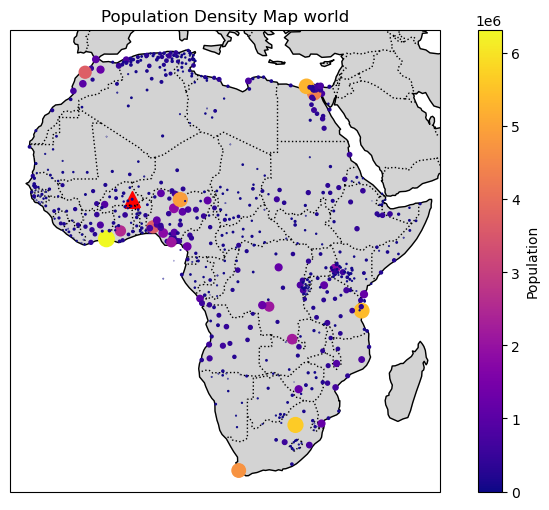

In [311]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


# Ajout des frontières des pays et des côtes
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, color='lightgray')

# Déterminez la taille des points en fonction de la densité de population
# Vous pouvez ajuster le facteur multiplicatif selon vos préférences
size = population_density*0.00002


# Affichage des densités de population en tant que points colorés
sc = ax.scatter(lats, lons, c=population_density, cmap='plasma',
                s=size, transform=ccrs.PlateCarree(), zorder=3)
plt.colorbar(sc, label='Population')

for i in range(N) : 
    plt.scatter(resultat.x[2*i+1], resultat.x[2*i], marker = "^", color = "red", s = 130)
# Ajouter des titres et des légendes
ax.set_title('Population Density Map world')
plt.show()

Il est clair et net qu'on rencontre un problème ici, c'est que notre algorithme converge vers un minimum local qui n'est certainement pas global. On le remarque aisément grâce aux sattelites déployés dans le désert, en effet, ils pourraient être déployés à cape town qui est une grosse ville et qui dans cette solution ne dispose pas de satelites alors que normalement, on devrait avoir un satelitte à cape town vu que c'est une ville importante

On est donc face au défi suivant :  dans le cadre d'un problème d'opti non convexe, comment faire pour savoir si la solution obtenue est un locale ou globale ? 

La méthode proposée ici est de partir de points de départ aléatoires, de faire tourner l'algorithme k fois à partir des k points de départ aléatoires et de séléctionner parmis les k la solution la plus avantageuse. 

In [275]:
K = 100
x0K = list()
result_objective = 0
sol = list()
for k in range(K) : 
    print(k, end = " ")
    x0 = [0.0] * 2*N
    for i in range(N) : 
        x0[2*i] = np.random.uniform(-55, 40)
        x0[2*i+1] = np.random.uniform(-35, 60)
    resultat = minimize(objectif, x0, method='Powell')
    if resultat.fun < result_objective : 
        result_objective = resultat.fun
        x0K = x0
        sol = resultat.x

print("FINISHED")
print("Nouveau resultat : ", result_objective)

    
        

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 FINISHED
Nouveau resultat :  -120280682.66072586


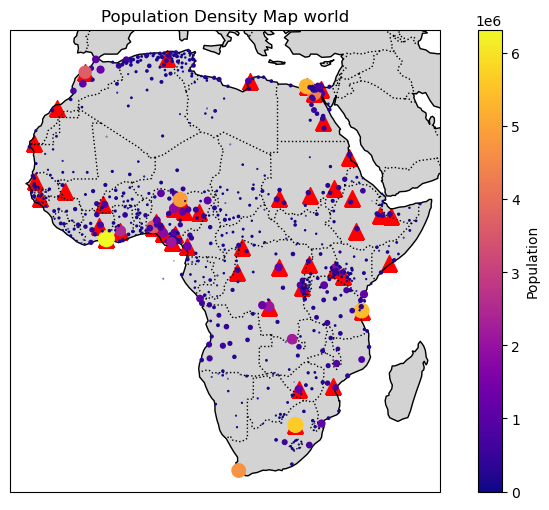

In [276]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


# Ajout des frontières des pays et des côtes
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, color='lightgray')

# Déterminez la taille des points en fonction de la densité de population
# Vous pouvez ajuster le facteur multiplicatif selon vos préférences
size = population_density*0.00002


# Affichage des densités de population en tant que points colorés
sc = ax.scatter(lats, lons, c=population_density, cmap='plasma',
                s=size, transform=ccrs.PlateCarree(), zorder=3)
plt.colorbar(sc, label='Population')


# Ajouter des titres et des légendes
ax.set_title('Population Density Map world')
for i in range(N) : 
    ax.scatter(sol[2*i+1], sol[2*i], marker = "^", color = "red", s = 130)
plt.show()

In [277]:
#Calcul du pourcentage de la population au moins atteinte : 

@numba.jit(nopython = True)
def One_Zero(Imin, I) : 
    if I >= Imin : return 1
    return 0

@numba.jit(nopython = True, parallel = True)
def objectif_verif(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = haversine(lats[j], lons[j], x[2*i+1], x[2*i]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += One_Zero(Imin, sumj/(population[j]+0.1))*population[j]
        
    return somme

print(objectif_verif(sol)/sum(population))

0.7559260429150614
